# Speech XAI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset, load_dataset
from IPython.display import display
import numpy as np 
import os
import pandas as pd
from pathlib import Path
from pydub import AudioSegment
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

from ferret import SpeechBenchmark, AOPC_Comprehensiveness_Evaluation_Speech, AOPC_Sufficiency_Evaluation_Speech

/home/moscato/miniconda3/envs/ferret-testing-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/moscato/miniconda3/envs/ferret-testing-2/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


In [3]:
DATASET_ID = "DynamicSuperb/IntentClassification_FluentSpeechCommands-Action"

In [4]:
# Note: set the ordinal of the device according to your system.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data

In [5]:
data = load_dataset(DATASET_ID, split="test")
data

Dataset({
    features: ['file', 'speakerId', 'transcription', 'audio', 'label', 'instruction'],
    num_rows: 200
})

In [6]:
sample = data[0]
sample

{'file': 'wavs/speakers/Xygv5loxdZtrywr9/77506ae0-452b-11e9-a843-8db76f4b5e29.wav',
 'speakerId': 'Xygv5loxdZtrywr9',
 'transcription': 'Increase the temperature in the washroom',
 'audio': {'path': '77506ae0-452b-11e9-a843-8db76f4b5e29.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.02133179, 0.01977539,
         0.01849365]),
  'sampling_rate': 16000},
 'label': 'increase',
 'instruction': 'Recognize the action behind the verbal expression. The answer could be activate, bring, change language, deactivate, decrease, or increase.'}

In this notebook we are using Wav2Vec2 which expects audio arrays to be in 16kHz. Luckly, this is the native sampling rate of our data. 

## Models

In [7]:
## Load model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)

if torch.cuda.is_available():
    model = model.to(device)

Some weights of the model checkpoint at superb/wav2vec2-base-superb-ic were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-ic and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_em

## Speech-XAI: the `SpeechBenchmark` class

Note: if not specified otherwise, `SpeechBenchmark` assumes English as the source language.

In [8]:
## Instantiate benchmark class
benchmark = SpeechBenchmark(model, feature_extractor, device=device)

Let's start from transcribing the example above using WhisperX.

In [9]:
text, word_timestamps = benchmark.transcribe(
    sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"],
)
text, word_timestamps

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1+cu121. Bad things might happen unless you revert torch to 1.x.


(' Increase the temperature in the washroom.',
 [{'word': 'Increase', 'start': 0.737, 'end': 1.02, 'score': 0.438},
  {'word': 'the', 'start': 1.04, 'end': 1.121, 'score': 0.141},
  {'word': 'temperature', 'start': 1.141, 'end': 1.526, 'score': 0.444},
  {'word': 'in', 'start': 1.546, 'end': 1.627, 'score': 0.848},
  {'word': 'the', 'start': 1.647, 'end': 1.728, 'score': 0.953},
  {'word': 'washroom.', 'start': 1.768, 'end': 2.132, 'score': 0.588}])

## Explain word importance

### Word importance

In [10]:
explanation = benchmark.explain(
    audio_path_or_array=sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"],
    methodology='LOO',
    word_timestamps=word_timestamps
)
# display(benchmark.show_table(explanation, decimals=3))
print(explanation)

ExplanationSpeech(features=['Increase', 'the', 'temperature', 'in', 'the', 'washroom.'], scores=array([[ 0.47325889, -0.45515126, -0.10200202, -0.15734476, -0.1214807 ,
         0.0109534 ],
       [ 0.07733703, -0.02064097,  0.34651214, -0.01588559, -0.01463729,
        -0.02365428],
       [-0.01432282, -0.01848161, -0.00988954, -0.00070852, -0.01123005,
         0.32860351]]), explainer='loo_speech+silence', target=[3, 4, 3], audio=<ferret.speechxai_utils.FerretAudio object at 0x7f7f6a2532e0>, word_timestamps=[{'word': 'Increase', 'start': 0.737, 'end': 1.02, 'score': 0.438}, {'word': 'the', 'start': 1.04, 'end': 1.121, 'score': 0.141}, {'word': 'temperature', 'start': 1.141, 'end': 1.526, 'score': 0.444}, {'word': 'in', 'start': 1.546, 'end': 1.627, 'score': 0.848}, {'word': 'the', 'start': 1.647, 'end': 1.728, 'score': 0.953}, {'word': 'washroom.', 'start': 1.768, 'end': 2.132, 'score': 0.588}])


In [11]:
explanation = benchmark.explain(
    audio_path_or_array=sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"], 
    methodology='LIME',
    word_timestamps=word_timestamps
)
print(explanation)
#display(benchmark.show_table(explanation, decimals=3))

ExplanationSpeech(features=['Increase', 'the', 'temperature', 'in', 'the', 'washroom.'], scores=array([[ 2.73476344e-01, -2.75996750e-02,  2.68968727e-02,
         4.38229965e-02, -9.83699882e-03,  3.43606337e-02],
       [-4.55664854e-02,  2.00781865e-04,  3.07805077e-01,
        -7.30899444e-03,  8.18159192e-03,  1.45066601e-01],
       [ 7.67945654e-02, -1.63121489e-02,  1.69544356e-01,
         1.03233346e-02,  6.95427875e-02,  4.02942513e-01]]), explainer='LIME+silence', target=[3, 4, 3], audio=<ferret.speechxai_utils.FerretAudio object at 0x7f7f6a2538b0>, word_timestamps=[{'word': 'Increase', 'start': 0.737, 'end': 1.02, 'score': 0.438}, {'word': 'the', 'start': 1.04, 'end': 1.121, 'score': 0.141}, {'word': 'temperature', 'start': 1.141, 'end': 1.526, 'score': 0.444}, {'word': 'in', 'start': 1.546, 'end': 1.627, 'score': 0.848}, {'word': 'the', 'start': 1.647, 'end': 1.728, 'score': 0.953}, {'word': 'washroom.', 'start': 1.768, 'end': 2.132, 'score': 0.588}])


We can run the same function but with no word timestamps. The class will generate them automatically.

In [12]:
explanation = benchmark.explain(
    audio_path_or_array=sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"], 
    methodology='LIME',
)
print(explanation)
#display(benchmark.show_table(explanation, decimals=3))

Transcribing audio to get word level timestamps...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1+cu121. Bad things might happen unless you revert torch to 1.x.
Transcribed audio with whisperX into:  Increase the temperature in the washroom.
ExplanationSpeech(features=['Increase', 'the', 'temperature', 'in', 'the', 'washroom.'], scores=array([[ 0.30518981, -0.05905296,  0.02406044,  0.06312683, -0.01027067,
         0.00634836],
       [-0.00192932,  0.04791306,  0.30365684,  0.01351914, -0.02577573,
         0.13388129],
       [ 0.0786875 , -0.029679  ,  0.21510288,  0.02970933,  0.03952171,
         0.44306297]]), explainer='LIME+silence', target=[3, 4, 3], audio=<ferret.speechxai_utils.FerretAudio object at 0x7f80c7375d20>, word_timestamps=[{'word': 'Increase', 'start': 0.737, 'end': 1.02, 'score': 0.438}, {'word': 'the', 'start': 1.04, 'end': 1.121, 'score': 0.141}, {'word': 'temperature', 'start

In [13]:
aopc_compr = AOPC_Comprehensiveness_Evaluation_Speech(benchmark.model_helper)
evaluation_output_c = aopc_compr.compute_evaluation(explanation)

aopc_suff = AOPC_Sufficiency_Evaluation_Speech(benchmark.model_helper)
evaluation_output_s = aopc_suff.compute_evaluation(explanation)

evaluation_output_c, evaluation_output_s

(EvaluationSpeech(name='aopc_compr_speech', score=[0.3684087162837386, 0.24896559864282608, 0.5148161184042692], target=[3, 4, 3]),
 EvaluationSpeech(name='aopc_suff', score=[0.014175561256706715, -0.004319146275520325, -0.01769007444381714], target=[3, 4, 3]))

## Explain paralinguistic impact

In [14]:
explain_table = benchmark.explain(
    audio_path_or_array=sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"],
    methodology='perturb_paraling',
)
display(benchmark.show_table(explain_table, decimals=2))

Perturbation type: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:15<00:00,  9.44s/it]


,pitch shifting,pitch shifting down,pitch shifting up,time stretching,time stretching down,time stretching up,reverberation,noise
action=increase,0.31,0.24,0.41,0.33,0.33,0.33,0.24,0.27
object=heat,0.25,0.19,0.33,-0.02,-0.02,-0.02,-0.00,0.23
location=washroom,0.02,0.02,0.02,-0.02,-0.02,-0.02,-0.01,0.70


## Show variation

In [15]:
perturbation_types = ['time stretching', 'pitch shifting', 'reverberation', 'noise']
variations_table = benchmark.explain_variations(
    audio_path_or_array=sample["audio"]["array"],
    current_sr=sample["audio"]["sampling_rate"],
    perturbation_types=perturbation_types
)

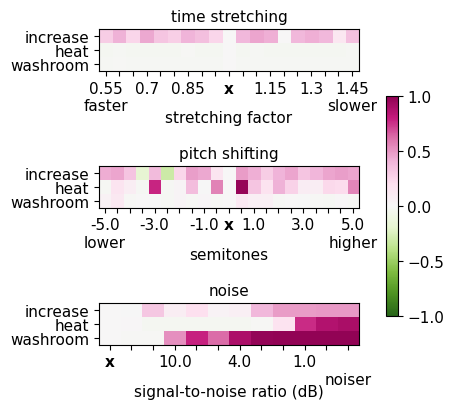

In [16]:
variations_table_plot = {k:variations_table[k] for k in variations_table if k in ['time stretching', 'pitch shifting', 'noise']}
fig = benchmark.plot_variations(variations_table_plot, show_diff = True, figsize=(4.6, 4.2));
# fig.savefig(f'example_{dataset_name}_context.pdf', bbox_inches='tight')